In [1]:
# Import libraries
import math
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP, FixedNoiseGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood, SumMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement, qNoisyExpectedImprovement
from botorch.acquisition.analytic import ProbabilityOfImprovement
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import GreaterThan, Interval
from botorch.sampling import IIDNormalSampler
from botorch.optim import optimize_acqf
from sklearn.preprocessing import StandardScaler
from botorch.models.converter import batched_to_model_list, model_list_to_batched

from kernel import SE, Matern 

## Single objective optimization

In [2]:
### CHANGE ###
## Add folder path
os.chdir(r'')
# Import the x and y data
df_xy = pd.read_csv(".csv", delim_whitespace=True, header=None)

# Extract the first column as x and convert to a 1D Numpy array
x = df_xy.iloc[:, 0].values

# Extract the second column as y and convert to a 2D Numpy array
y = df_xy.iloc[:, 1].values

# Convert x and y numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
x_tensor = x_tensor.view(x_tensor.shape[0], 1)
y_tensor = torch.tensor(y, dtype=torch.float32)
print("Shape of x tensor", x_tensor.shape)
print("Shape of y tensor", y_tensor.shape)


### CHANGE ###
# Set the range of the parameter space
x_range = np.array([90, 130])                      

Shape of x tensor torch.Size([9, 1])
Shape of y tensor torch.Size([9])


In [13]:
x_tensor = torch.tensor([[100.],
        [ 95.],
        [ 90.],
        [125.],
        [115.],
        [120.],
        [130.],
        [112.]])

y_tensor = torch.tensor([61., 56., 57., 59., 63., 60., 61., 64.])

In [14]:
y_tensor

tensor([61., 56., 57., 59., 63., 60., 61., 64.])

In [15]:
# Define kernel and Likelihood (kernel contains the hyperparameters length scale and output scale variance, while the likelihood contains the hyperparameter noise variance)
kernel = SE(1) # argument n_parms = 1
covar_module = kernel.get_covr_module()   # open HIL.optimization.kernel.py and set the limits of the lengthscale variance and output scale variance.
noise_range = np.array([0.01, 1.0])  # Set the limits for the noise range
likelihood = GaussianLikelihood(noise_constraint = Interval(noise_range[0], noise_range[1]))

# # The kernel specifies the covariance (or similarity) between different points in the input space. 
# # It determines how the output values at different input points are correlated.
# # In other words, the kernel captures the smoothness and correlations in the underlying function 

# # The likelihood models the noise or uncertainty in the observed data. 
# # It represents the probability distribution of the observed output given the true underlying function values 
# # predicted by the GP.

In [16]:
# Tune the hyperparameters and fit the GP model

# Train the model and tune the hyperparameters using Adam optimizer)
def _training_single_objective_Adam(train_x, train_y, likelihood, covar_module):
    """
    Train the single-objective model using Adam Optimizer and gradient descent.
    Log Marginal Likelihood is used as the cost function.
    """

    # Initialize the single objective Gaussian Process model with the likelihood and kernel
    single_objective_model = SingleTaskGP(train_x, train_y.unsqueeze(-1), likelihood = likelihood, covar_module = covar_module)

    # Set up the Adam optimizer
    parameters = list(single_objective_model.parameters()) #+ list(likelihood.parameters())
    optimizer = torch.optim.Adam(parameters, lr=0.01)
    
    # Training loop
    for epoch in range(1000):
        
        optimizer.zero_grad()

        # Forward pass to get the output from the model
        # During the forward pass, operations are performed on tensors, and a computation graph is built to represent the sequence of operations.

        # Loss Calculation: At the end of the forward pass, a scalar tensor is usually obtained, representing the loss or objective function. 
        # This scalar tensor is what you want to minimize during training.

        output = single_objective_model(train_x)
            
        # Calculate Exact Marginal Log Likelihood (loss function) for the current model
        mll = ExactMarginalLogLikelihood(single_objective_model.likelihood, single_objective_model)
        loss = -mll(output, train_y) 

        # Backward pass 
        # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
        # respect to each parameter of the model. 
        loss.backward()
        
        # Optimization step (Parameter update)
        # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
        optimizer.step()
        
        # Print the loss after every 50 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
        
        
    # Extract optimized hyperparameters
  
    # Hyperparameters of the covariance module (kernel)
    output_scale = single_objective_model.covar_module.outputscale.item()
    length_scale = single_objective_model.covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance = single_objective_model.likelihood.noise_covar.noise.item()

    return single_objective_model, output_scale, length_scale, noise_variance


# Train the GP models and tune the hyperparameters using fit_gpytorch_model

# # fit_gpytorch_model(mll) is a method provided by BoTorch (a library built on top of PyTorch) that 
# # performs hyperparameter optimization for Gaussian Process (GP) models. It is an alternative way to optimize the hyperparameters 
# # of the GP model compared to using a separate optimizer.

def _training_single_objective_gpytorch(train_x, train_y, likelihood, covar_module): 
    """
    Train the single-objective model using fit_gpytorch_model.
    Log Marginal Likelihood is used as the cost function.
    """
    
    # Initialize the single objective Gaussian Process model with the likelihood and kernel
    single_objective_model = SingleTaskGP(train_x, train_y.unsqueeze(-1), likelihood = likelihood, covar_module = covar_module)

    
    loss = ExactMarginalLogLikelihood(single_objective_model.likelihood, single_objective_model)

    # Fit the model (optimize hyperparameters)
    fit_gpytorch_model(loss)

    # Extract optimized hyperparameters
  
    # Hyperparameters of the covariance module (kernel)
    output_scale = single_objective_model.covar_module.outputscale.item()
    length_scale = single_objective_model.covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance = single_objective_model.likelihood.noise_covar.noise.item()

    return single_objective_model, output_scale, length_scale, noise_variance

In [20]:
# Call the _training_single_objective_Adam method, which optimizes the hyperparameters and fits the model, returns the trained model list and optimized hyperparameters
trained_model, os, ls, nv = _training_single_objective_Adam(x_tensor, y_tensor, likelihood, covar_module)  

# Call the _training_multi_objective_gpytorch method, which optimizes the hyperparameters and fits the model, returns the trained model list and optimized hyperparameters
#trained_model, os, ls, nv = _training_single_objective_gpytorch(x_tensor, y_tensor, likelihood, covar_module)


C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([60.1250]), std = tensor([2.7484])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(m

Epoch 0, Loss: 7.6423845291137695
Epoch 50, Loss: 7.562252044677734
Epoch 100, Loss: 7.4832353591918945
Epoch 150, Loss: 7.405366897583008
Epoch 200, Loss: 7.328629493713379
Epoch 250, Loss: 7.2529988288879395
Epoch 300, Loss: 7.178467750549316
Epoch 350, Loss: 7.10501766204834
Epoch 400, Loss: 7.032639503479004
Epoch 450, Loss: 6.961311340332031
Epoch 500, Loss: 6.891021728515625
Epoch 550, Loss: 6.821766376495361
Epoch 600, Loss: 6.75352144241333
Epoch 650, Loss: 6.686278343200684
Epoch 700, Loss: 6.620029449462891
Epoch 750, Loss: 6.554749011993408
Epoch 800, Loss: 6.490441799163818
Epoch 850, Loss: 6.4270853996276855
Epoch 900, Loss: 6.3646697998046875
Epoch 950, Loss: 6.303194046020508


In [21]:
# Generate test points in the range of the parameter space, for plotting
test_x = torch.linspace(x_range[0], x_range[1], 100).unsqueeze(-1)

# Make predictions for the test points - Obtain the posterior predictive distribution for the test points
trained_model.eval()
scaling_factor = 1.96 
observed = []
observed_mean = []
std_dev = []
lower = []
upper = []

with torch.no_grad():
    # Get the posterior distribution for model
    observed = trained_model.likelihood(trained_model(test_x))
        
    # Extract mean and variance
    observed_mean = observed.mean.cpu().numpy()
        
    # print(observed_mean)
    std_dev = observed.stddev.cpu().numpy()
        
    # Obtain the confidence intervals
    upper = observed_mean + scaling_factor * std_dev
    lower = observed_mean - scaling_factor * std_dev

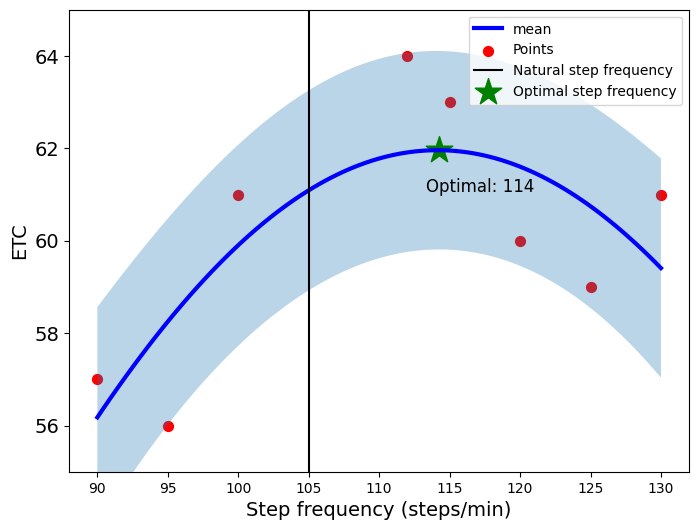

In [24]:
# Plot the trained Gaussian Process model
# Find the point of maximum mean for the first objective
max_index_1 = np.argmax(observed_mean)
max_test_x_1 = test_x[max_index_1].item()
max_observed_mean_1 = observed_mean[max_index_1]


# Plot the GP 
plt.figure(figsize=(8, 6))
plt.plot(test_x, observed_mean, label='mean', linewidth=3, color='b')
plt.scatter(x_tensor, y_tensor, label='Points', color='r', marker='o', s=50)
plt.fill_between(test_x.squeeze(), lower.squeeze(), upper.squeeze(), alpha=0.3)
plt.yticks(fontsize=14)
plt.ylim(y_tensor.min()-1, y_tensor.max()+1)
plt.xlabel('Step frequency (steps/min)', fontsize=14)
plt.ylabel('ETC', fontsize=14)
plt.axvline(x = 105, color = 'k', label = 'Natural step frequency')

# Add a star marker at the maximum observed mean point
plt.scatter(max_test_x_1, max_observed_mean_1, color='g', marker='*', s=400, label='Optimal step frequency')

# Annotate the star with the optimal parameter value
plt.annotate(f'Optimal: {max_test_x_1:.0f}', 
             (max_test_x_1, max_observed_mean_1),
             textcoords="offset points", 
             xytext=(30,-30),  # Move the text 10 points right, -10 points down
             ha='center', 
             fontsize=12, 
             color='black')

plt.legend(fontsize=10)
plt.savefig('gp_objective.png', dpi=300, bbox_inches='tight')
plt.show()

### Hyperparameter history

In [ ]:
# Hyperparameter time series
# If using Adam optimizer

output_scale_list = []
length_scale_list = []
noise_variance_list = []


for n in range(3, len(x_tensor)):
    trained_model_list, os, ls, nv = _training_single_objective_Adam(x_tensor[:n], y_tensor[:n])
    output_scale_list.append(os)
    length_scale_list.append(ls)
    noise_variance_list.append(nv)


# # If using the fit_gpytorch_model optimizer
# output_scale_list = []
# length_scale_list = []
# noise_variance_list = []

# for n in range(3, len(x_tensor)):
#     trained_model_list, os, ls, nv = _training_single_objective_gpytorch(x_tensor[:n], y_tensor[:n])
#     output_scale_list.append(os)
#     length_scale_list.append(ls)
#     noise_variance_list.append(nv)

In [ ]:
# plotting noise var
# plt.figure(figsize=(8, 6))

iterations = range(3, len(x_tensor), 1)  
plt.subplot(2, 3, 1)
plt.plot(iterations, noise_variance_list, marker='o', linestyle='-', color='blue')
plt.title(f'Noise variance versus iterations')
plt.xlabel('Iteration')
plt.ylabel('Noise variance')
plt.grid(True)


# plotting length scale

#plt.figure(figsize=(8, 6))
plt.subplot(2, 3, 2)
plt.plot(iterations, length_scale_list, marker='o', linestyle='-', color='red')
plt.title(f'Length scale versus iterations')
plt.xlabel('Iteration')
plt.ylabel('Length scale')
plt.grid(True)


# plotting output scale variance

#plt.figure(figsize=(8, 6))
plt.subplot(2, 3, 3)
plt.plot(iterations, output_scale_list, marker='o', linestyle='-', color='green')
plt.title(f'Output scale versus iterations')
plt.xlabel('Iteration')
plt.ylabel('Output scale')
plt.grid(True)

## Multi-objective optimization

In [177]:
# Import data

### CHANGE ###
os.chdir(r'')
# Import the x and y data
df_xy = pd.read_csv("data_9_25_24.csv", delim_whitespace=True, header=None)
# df_xy = pd.read_csv("data_9_6_24.csv", header=None, skiprows=[0])

# Extract the first column as x and convert to a 1D Numpy array
x = df_xy.iloc[:, 0].values

# Extract the second and third columns as a vector of two objectives (y1 and y2), and convert to a 2D Numpy array
y = df_xy.iloc[:, 1:].values

# Convert x and y numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
x_tensor = x_tensor.view(x_tensor.shape[0], 1)
y_tensor = torch.tensor(y, dtype=torch.float32)
print("Shape of x tensor", x_tensor.shape)
print("Shape of y tensor", y_tensor.shape)

### CHANGE ###
# Set the range of the parameter space
x_range = np.array([0.1, 0.7])    

Shape of x tensor torch.Size([8, 1])
Shape of y tensor torch.Size([8, 2])


In [186]:
# Define kernel and Likelihood (kernel contains the hyperparameters length scale and output scale variance, while the likelihood contains the hyperparameter noise variance)
kernel = SE(1) # argument n_parms = 1
covar_module = kernel.get_covr_module()   # open HIL.optimization.kernel.py and set the limits of the lengthscale variance and output scale variance.

noise_range_1 = np.array([0.01, 1])  # Set the limits for the noise range for objective 1
noise_range_2 = np.array([0.01, 1])  # Set the limits for the noise range for objective 2

likelihood_1 = GaussianLikelihood(noise_constraint = Interval(noise_range_1[0], noise_range_1[1]))
likelihood_2 = GaussianLikelihood(noise_constraint = Interval(noise_range_2[0], noise_range_2[1]))

# Store the likelihoods as a list
likelihood = []
likelihood.append(likelihood_1)
likelihood.append(likelihood_2)

In [192]:
# Train the models and tune the hyperparameters using Adam optimizer
def _training_multi_objective_Adam(train_x, train_y, likelihood, covar_module):
    """
    Train the multi-objective model using Adam Optimizer and gradient descent.
    Log Marginal Likelihood is used as the cost function.
    """
    num_objectives = train_y.shape[-1]

    # Initialize a list to store individual GP models for each objective
    models = []
    for i in range(num_objectives):
        # Create a SingleTaskGP for each objective
        single_objective_model = SingleTaskGP(train_x, train_y[:, i].unsqueeze(-1), likelihood = likelihood[i], covar_module = covar_module) 
        models.append(single_objective_model)

    # Create a ModelListGP to manage multiple objectives
    model_list = ModelListGP(*models)
    
    # Set up the optimizer
    parameters = list(model_list.parameters()) #+ list(likelihood[0].parameters()) + list(likelihood[1].parameters())
    optimizer = torch.optim.Adam(parameters, lr=0.001)
    
    # Training loop
    for epoch in range(1500):
        
        optimizer.zero_grad()
        
        # Loop over individual models in the ModelListGP
        for i, model in enumerate(model_list.models):
            # Forward pass to get the output from the model
            # During the forward pass, operations are performed on tensors, and a computation graph is built to represent the sequence of operations.

            # Loss Calculation: At the end of the forward pass, a scalar tensor is usually obtained, representing the loss or objective function. 
            # This scalar tensor is what you want to minimize during training.

            output = model(train_x)
            
            # Calculate Exact Marginal Log Likelihood (loss function) for the current model
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            loss = -mll(output, train_y[:, i]) 
            
            # Backward pass 
            # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
            # respect to each parameter of the model. 
            loss.backward()
        
            # Optimization step (Parameter update)
            # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
            optimizer.step()
        
            # Print the loss after every 50 epochs
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    # Extract optimized hyperparameters
  
    # Objective 1
    # Hyperparameters of the covariance module (kernel)
    output_scale_1 = model_list.models[0].covar_module.outputscale.item()
    length_scale_1 = model_list.models[0].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_1 = model_list.models[0].likelihood.noise_covar.noise.item()

    # Objective 2
    # Hyperparameters of the covariance module (kernel)
    output_scale_2 = model_list.models[1].covar_module.outputscale.item()
    length_scale_2 = model_list.models[1].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_2 = model_list.models[1].likelihood.noise_covar.noise.item()

    return model_list, output_scale_1, length_scale_1, noise_variance_1, output_scale_2, length_scale_2, noise_variance_2



# Train the models and tune the hyperparameters using fit_gpytorch_model
def _training_multi_objective_gpytorch(train_x, train_y): 
    models = []
    for i in range(train_y.shape[-1]):
        train_objective = train_y[:, i]
        models.append(
            SingleTaskGP(train_x, train_objective.unsqueeze(-1))
        )
    model_list = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model_list.likelihood, model_list)

    # Fit the model (optimize hyperparameters)
    fit_gpytorch_model(mll)

    # Extract optimized hyperparameters
  
    # Objective 1
    # Hyperparameters of the covariance module (kernel)
    output_scale_1 = model_list.models[0].covar_module.outputscale.item()
    length_scale_1 = model_list.models[0].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_1 = model_list.models[0].likelihood.noise_covar.noise.item()

    # Objective 2
    # Hyperparameters of the covariance module (kernel)
    output_scale_2 = model_list.models[1].covar_module.outputscale.item()
    length_scale_2 = model_list.models[1].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_2 = model_list.models[1].likelihood.noise_covar.noise.item()

    return model_list, output_scale_1, length_scale_1, noise_variance_1, output_scale_2, length_scale_2, noise_variance_2


# Train the models and tune the hyperparameters using fit_gpytorch_model
def _training_multi_objective_gpytorch_2(train_x, train_y, likelihood, covar_module): 
    models = []
    for i in range(train_y.shape[-1]):
        train_objective = train_y[:, i]
        models.append(
            SingleTaskGP(train_x, train_y[:, i].unsqueeze(-1), likelihood = likelihood[i], covar_module = covar_module) 
        )
    model_list = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model_list.likelihood, model_list)

    # Fit the model (optimize hyperparameters)
    fit_gpytorch_model(mll)

    # Extract optimized hyperparameters
  
    # Objective 1
    # Hyperparameters of the covariance module (kernel)
    output_scale_1 = model_list.models[0].covar_module.outputscale.item()
    length_scale_1 = model_list.models[0].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_1 = model_list.models[0].likelihood.noise_covar.noise.item()

    # Objective 2
    # Hyperparameters of the covariance module (kernel)
    output_scale_2 = model_list.models[1].covar_module.outputscale.item()
    length_scale_2 = model_list.models[1].covar_module.base_kernel.lengthscale.item()

    # Hyperparameters of the likelihood
    noise_variance_2 = model_list.models[1].likelihood.noise_covar.noise.item()

    return model_list, output_scale_1, length_scale_1, noise_variance_1, output_scale_2, length_scale_2, noise_variance_2



In [193]:
# # Call the _training_multi_objective_Adam method, which optimizes the hyperparameters and fits the model, returns the trained model list and optimized hyperparameters
trained_model_list, os_1, ls_1, nv_1, os_2, ls_2, nv_2 = _training_multi_objective_Adam(x_tensor, y_tensor, likelihood, covar_module)


#Call the _training_multi_objective_gpytorch method, which optimizes the hyperparameters and fits the model, returns the trained model list and optimized hyperparameters
#trained_model_list, os_1, ls_1, nv_1, os_2, ls_2, nv_2 = _training_multi_objective_gpytorch(x_tensor, y_tensor)
#trained_model_list, os_1, ls_1, nv_1, os_2, ls_2, nv_2 = _training_multi_objective_gpytorch_2(x_tensor, y_tensor, likelihood, covar_module)

Epoch 0, Loss: 2.7583932876586914
Epoch 0, Loss: 6495.81689453125
Epoch 50, Loss: 2.698641061782837
Epoch 50, Loss: 6323.4443359375
Epoch 100, Loss: 2.6460087299346924
Epoch 100, Loss: 6163.35498046875
Epoch 150, Loss: 2.5991926193237305
Epoch 150, Loss: 6014.353515625
Epoch 200, Loss: 2.557192087173462
Epoch 200, Loss: 5874.94482421875
Epoch 250, Loss: 2.5192322731018066
Epoch 250, Loss: 5743.814453125
Epoch 300, Loss: 2.48469614982605
Epoch 300, Loss: 5619.77099609375
Epoch 350, Loss: 2.4530835151672363
Epoch 350, Loss: 5501.70263671875
Epoch 400, Loss: 2.423992395401001
Epoch 400, Loss: 5388.63720703125
Epoch 450, Loss: 2.397094964981079
Epoch 450, Loss: 5279.6328125
Epoch 500, Loss: 2.372121572494507
Epoch 500, Loss: 5173.880859375
Epoch 550, Loss: 2.3488564491271973
Epoch 550, Loss: 5070.68994140625
Epoch 600, Loss: 2.327127695083618
Epoch 600, Loss: 4969.55859375
Epoch 650, Loss: 2.306798219680786
Epoch 650, Loss: 4870.1904296875
Epoch 700, Loss: 2.2877702713012695
Epoch 700, Los

In [202]:
# Generate test points in the range of the parameter space, for plotting
test_x = torch.linspace(x_range[0], x_range[1], 100).unsqueeze(-1)

# Make predictions for the test points
# Iterate over models and get the posterior predictive distribution for the test points

trained_model_list.eval()
scaling_factor = [1.96, 1.96] 
observed = []
observed_mean = []
std_dev = []
lower = []
upper = []

with torch.no_grad():
    # Loop through each model in the list
    for i, model in enumerate(trained_model_list.models):
        # Get the posterior distribution for the i-th model
        observed_i = model.likelihood(model(test_x))
        
        # Extract mean and variance
        observed_mean_i = observed_i.mean.cpu().numpy()
        
        # print(observed_mean_i)
        std_dev_i = observed_i.stddev.cpu().numpy()
        
        # Obtain the confidence intervals
        upper_i = observed_mean_i + scaling_factor[i] * std_dev_i
        lower_i = observed_mean_i - scaling_factor[i] * std_dev_i

        observed.append(observed_i)
        observed_mean.append(observed_mean_i)
        std_dev.append(std_dev_i)
        lower.append(lower_i)
        upper.append(upper_i)

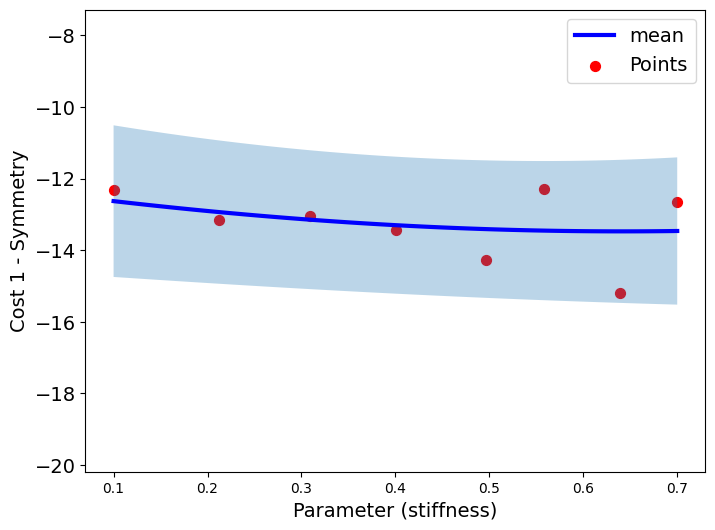

In [205]:
# Find the point of maximum mean for the first objective
max_index_1 = np.argmax(observed_mean[0])
max_test_x_1 = test_x[max_index_1].item()
max_observed_mean_1 = observed_mean[0][max_index_1]


# Plot the GP for the first objective
plt.figure(figsize=(8, 6))
plt.plot(test_x, observed_mean[0], label='mean', linewidth=3, color='b')
plt.scatter(x_tensor, y_tensor[:,0], label='Points', color='r', marker='o', s=50)
plt.fill_between(test_x.squeeze(), lower[0].squeeze(), upper[0].squeeze(), alpha=0.3)
plt.yticks(fontsize=14)
plt.ylim(y_tensor[:,0].min()-5, y_tensor[:,0].max()+5)
plt.xlabel('Parameter (stiffness)', fontsize=14)
plt.ylabel('Cost 1 - Symmetry', fontsize=14)

# # Add a star marker at the maximum observed mean point
# plt.scatter(max_test_x_1, max_observed_mean_1, color='g', marker='*', s=400, label='Optimal')

# # Annotate the star with the optimal parameter value
# plt.annotate(f'Best param (Obj 1): {max_test_x_1:.1f}', 
#              (max_test_x_1, max_observed_mean_1),
#              textcoords="offset points", 
#              xytext=(10,-10),  # Move the text 10 points right, -10 points down
#              ha='center', 
#              fontsize=12, 
#              color='black')

plt.legend(fontsize=14)

# Save the figure in high resolution
# plt.savefig('gp_objective_1.png', dpi=300, bbox_inches='tight')

plt.show()


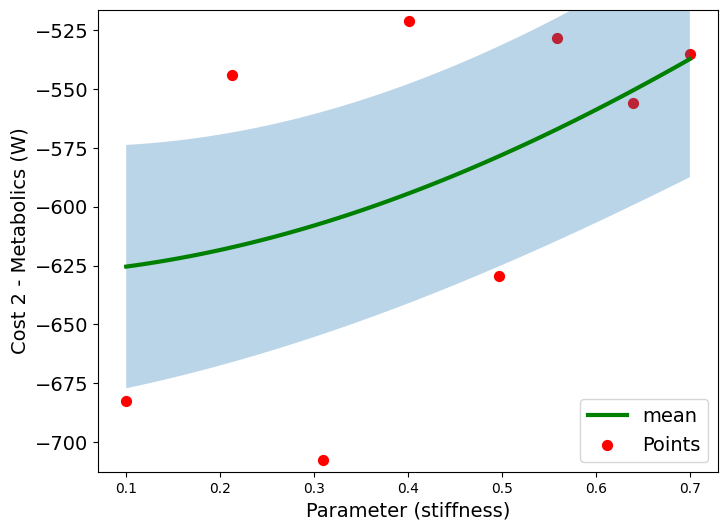

In [206]:
# Find the point of maximum mean for the second objective
max_index_2 = np.argmax(observed_mean[1])
max_test_x_2 = test_x[max_index_2].item()
max_observed_mean_2 = observed_mean[1][max_index_2]

# Plot the GP for the second objective 
plt.figure(figsize=(8, 6))
plt.plot(test_x, observed_mean[1], label='mean', linewidth=3, color='g')
plt.scatter(x_tensor, y_tensor[:,1], label='Points', color='r', marker='o', s=50)
plt.fill_between(test_x.squeeze(), lower[1].squeeze(), upper[1].squeeze(), alpha=0.3)
plt.yticks(fontsize=14)
plt.ylim(y_tensor[:,1].min()-5, y_tensor[:,1].max()+5)
plt.xlabel('Parameter (stiffness)', fontsize=14)
plt.ylabel('Cost 2 - Metabolics (W)', fontsize=14)

# # Add a star marker at the maximum observed mean point for the second objective
# plt.scatter(max_test_x_2, max_observed_mean_2, color='b', marker='*', s=400, label='Optimal')

# # Annotate the star with the optimal parameter value for the second objective
# plt.annotate(f'Best param (Obj 2): {max_test_x_2:.1f}', 
#              (max_test_x_2, max_observed_mean_2), 
#              textcoords="offset points", 
#              xytext=(10,-10),  # Move the text 10 points right, -10 points down
#              ha='center', 
#              fontsize=12, 
#              color='black')

plt.legend(fontsize=14)
# Save the figure in high resolution
# plt.savefig('gp_objective_2.png', dpi=300, bbox_inches='tight')

plt.show()


In [207]:
# Normalize the observed means for both objectives
norm_observed_mean_0 = (observed_mean[0] - np.min(observed_mean[0])) / (np.max(observed_mean[0]) - np.min(observed_mean[0]))
norm_observed_mean_1 = (observed_mean[1] - np.min(observed_mean[1])) / (np.max(observed_mean[1]) - np.min(observed_mean[1]))

# Example weights and scalarization
weights = torch.tensor([0.5, 0.5])
alpha = 0.05
objective_values = np.column_stack((norm_observed_mean_0, norm_observed_mean_1))
weighted_values = weights * objective_values
scalarized_objective = weighted_values.min(dim=-1).values + alpha * weighted_values.sum(dim=-1)

# Find the point of maximum scalarized objective
max_scalarized_index = np.argmax(scalarized_objective)
max_test_x_scalarized = test_x[max_scalarized_index].item()
max_scalarized_value = scalarized_objective[max_scalarized_index]

In [175]:
max_test_x_scalarized

0.3787878751754761

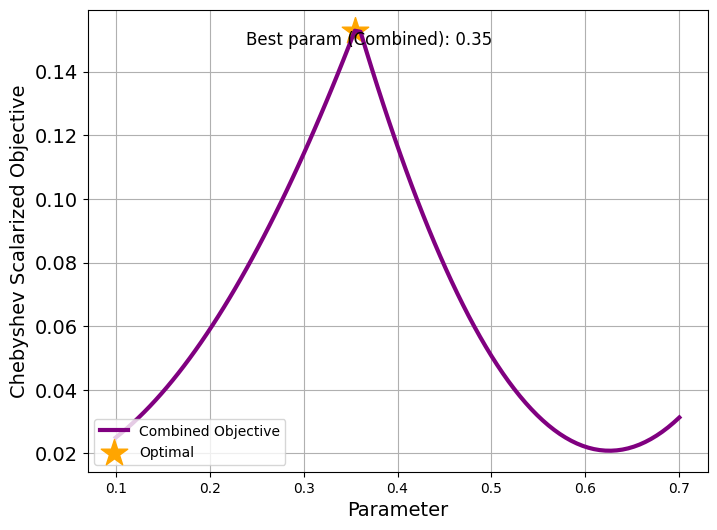

In [208]:
# Plot the scalarized objective
plt.figure(figsize=(8, 6))
plt.plot(test_x, scalarized_objective, label='Combined Objective', linewidth=3, color='purple')

# Add a star marker at the maximum scalarized objective point
plt.scatter(max_test_x_scalarized, max_scalarized_value.item(), color='orange', marker='*', s=400, label='Optimal')

# Annotate the star with the maximum scalarized objective parameter value
plt.annotate(f'Best param (Combined): {max_test_x_scalarized:.2f}', 
             (max_test_x_scalarized, max_scalarized_value.item()), 
             textcoords="offset points", 
             xytext=(10, -10),  
             ha='center', fontsize=12, color='black')

# Set labels and ticks
plt.xlabel('Parameter', fontsize=14)
plt.ylabel('Chebyshev Scalarized Objective', fontsize=14)
plt.yticks(fontsize=14)

# Move legend to bottom left
plt.legend(loc='lower left', fontsize=10)

# Add grid and show plot
plt.grid(True)
plt.savefig('Chebyshev_objective.png', dpi=300, bbox_inches='tight')
plt.show()

### Hyperparameter history

In [162]:
# # If using Adam optimizer

# output_scale_1_list = []
# length_scale_1_list = []
# noise_variance_1_list = []

# output_scale_2_list = []
# length_scale_2_list = []
# noise_variance_2_list = []


# for n in range(3, len(x_tensor)):
#     trained_model_list, os_1, ls_1, nv_1, os_2, ls_2, nv_2 = _training_multi_objective_Adam(x_tensor[:n], y_tensor[:n], likelihood, covar_module)
#     output_scale_1_list.append(os_1)
#     length_scale_1_list.append(ls_1)
#     noise_variance_1_list.append(nv_1)
#     output_scale_2_list.append(os_2)
#     length_scale_2_list.append(ls_2)
#     noise_variance_2_list.append(nv_2)


# If using the fit_gpytorch_model optimizer
output_scale_1_list = []
length_scale_1_list = []
noise_variance_1_list = []

output_scale_2_list = []
length_scale_2_list = []
noise_variance_2_list = []


for n in range(3, len(x_tensor)):
    trained_model_list, os_1, ls_1, nv_1, os_2, ls_2, nv_2 = _training_multi_objective_gpytorch(x_tensor[:n], y_tensor[:n])
    output_scale_1_list.append(os_1)
    length_scale_1_list.append(ls_1)
    noise_variance_1_list.append(nv_1)
    output_scale_2_list.append(os_2)
    length_scale_2_list.append(ls_2)
    noise_variance_2_list.append(nv_2)

C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-13.9236]), std = tensor([1.1032])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-540.5603]), std = tensor([17.6714])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussion

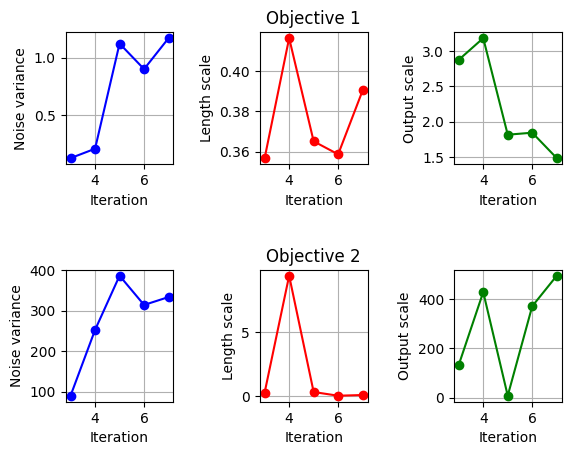

In [163]:
# Objective 1 (RMSSD)
# plotting noise var
# plt.figure(figsize=(8, 6))

iterations = range(3, len(x_tensor), 1)  
plt.subplot(2, 3, 1)
plt.plot(iterations, noise_variance_1_list, marker='o', linestyle='-', color='blue')
# plt.title(f'Noise variance \n Objective 1')
plt.xlabel('Iteration')
plt.ylabel('Noise variance')
plt.grid(True)


# plotting length scale

#plt.figure(figsize=(8, 6))
plt.subplot(2, 3, 2)
plt.plot(iterations, length_scale_1_list, marker='o', linestyle='-', color='red')
plt.title(f'Objective 1')
plt.xlabel('Iteration')
plt.ylabel('Length scale')
plt.grid(True)


# plotting output scale variance

#plt.figure(figsize=(8, 6))
plt.subplot(2, 3, 3)
plt.plot(iterations, output_scale_1_list, marker='o', linestyle='-', color='green')
# plt.title(f'Output scale \n Objective 1')
plt.xlabel('Iteration')
plt.ylabel('Output scale')
plt.grid(True)


# Objective 2 (ETC)
# plotting noise var
#plt.figure(figsize=(8, 6))
    
plt.subplot(2, 3, 4)  
plt.plot(iterations, noise_variance_2_list, marker='o', linestyle='-', color='blue')
# plt.title(f'Noise variance \n Objective 2')
plt.xlabel('Iteration')
plt.ylabel('Noise variance')
plt.grid(True)


# plotting length scale

#plt.figure(figsize=(8, 6))
plt.subplot(2, 3, 5)  
plt.plot(iterations, length_scale_2_list, marker='o', linestyle='-', color='red')
plt.title(f'Objective 2')
plt.xlabel('Iteration')
plt.ylabel('Length scale')
plt.grid(True)


# plotting output scale variance

#plt.figure(figsize=(8, 6))
plt.subplot(2, 3, 6)
plt.plot(iterations, output_scale_2_list, marker='o', linestyle='-', color='green')
# plt.title(f'Output scale \n Objective 2')
plt.xlabel('Iteration')
plt.ylabel('Output scale')
plt.grid(True)
plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()

## Multi-objective with RGPE

In [217]:
import os
import glob
import torch
import math
import pandas as pd


torch.manual_seed(29)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [218]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_list
from botorch.utils.transforms import unnormalize, normalize
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.utils.sampling import sample_simplex
from botorch.acquisition.objective import GenericMCObjective
from botorch.sampling import IIDNormalSampler
from botorch.sampling.normal import SobolQMCNormalSampler
# import numpy as np

from kernel import SE, Matern 

from gpytorch.kernels import RBFKernel,ScaleKernel
from gpytorch.priors import NormalPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval

In [219]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_mll

# Model fitting for RGPE target model ranking loss calculation - each objective separately 

# Fit model using fit_gpytorch_model
def get_fitted_model_SO(train_X, train_Y, state_dict=None):
    """
    Get a single task GP. The model will be fit unless a state_dict with model
        hyperparameters is provided.
    """
    Y_mean = train_Y.mean(dim=-2, keepdim=True)
    Y_std = train_Y.std(dim=-2, keepdim=True)
    
    # # FixedNoiseGP
    # model = FixedNoiseGP(train_X, (train_Y - Y_mean) / Y_std, train_Yvar)

    # SingleTaskGP
    batch_shape = torch.Size([train_X.size(0)])
    dimension = train_X.shape[1] # number of parameters
    
    model = SingleTaskGP(train_X, (train_Y - Y_mean) / Y_std)
    model.likelihood = GaussianLikelihood()

    # model = SingleTaskGP(train_X, (train_Y - Y_mean)/Y_std,covar_module=ScaleKernel(
    #         base_kernel=RBFKernel(ard_num_dims=dimension,lengthscale_prior=NormalPrior(0.1,0.9))
    #         ,outputscale_prior=NormalPrior(0.1,0.9)))
    # model.likelihood = GaussianLikelihood(noise_prior=NormalPrior(0.1,0.9),noise_constraint=Interval(0.00001,0.7))

    # model = SingleTaskGP(train_X, (train_Y - Y_mean)/Y_std)
    # model.likelihood = GaussianLikelihood(noise_constraint=Interval(0.00001,5.0))
    
    model.Y_mean = Y_mean
    model.Y_std = Y_std
    
    if state_dict is None:
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

    else:
        # # For SingleTaskGP
        model = SingleTaskGP(train_X, (train_Y - Y_mean)/Y_std)
        model.likelihood=GaussianLikelihood(batch_shape=batch_shape)
        
        # model = SingleTaskGP(train_X, (train_Y - Y_mean)/Y_std,covar_module=ScaleKernel(batch_shape=batch_shape,
        #             base_kernel=RBFKernel(batch_shape=batch_shape,lengthscale_prior=NormalPrior(0.1,0.9))
        #             ,outputscale_prior=NormalPrior(0.1,0.9)))
        # model.likelihood=GaussianLikelihood(noise_prior=NormalPrior(0.1,0.9),noise_constraint=Interval(0.00001,0.7),batch_shape=batch_shape)
        
        # model = SingleTaskGP(train_X, (train_Y - Y_mean)/Y_std)
        # model.likelihood=GaussianLikelihood(batch_shape=batch_shape, noise_constraint=Interval(0.00001,0.7))
        
        model.load_state_dict(state_dict)

        # # For FixedNoiseGP
        # model.load_state_dict(state_dict)
    
    return model



# # Fit model using Adam optimizer
# def get_fitted_model_SO(train_X, train_Y, state_dict=None):
#     """
#     Get a single task GP. The model will be fit unless a state_dict with model
#         hyperparameters is provided.
#     """
#     Y_mean = train_Y.mean(dim=-2, keepdim=True)
#     Y_std = train_Y.std(dim=-2, keepdim=True)

#     # FixedNoiseGP
#     # model = FixedNoiseGP(train_X, (train_Y - Y_mean) / Y_std, train_Yvar)

#     # SingleTaskGP
#     batch_shape = torch.Size([train_X.size(0)])
#     dimension = train_X.shape[1] # number of parameters
    
#     model = SingleTaskGP(train_X, (train_Y - Y_mean)/Y_std, covar_module=ScaleKernel(
#             base_kernel=RBFKernel(ard_num_dims=dimension,lengthscale_prior=NormalPrior(0.4,0.56))
#             ,outputscale_prior=NormalPrior(0.2,0.56)))
#     model.likelihood = GaussianLikelihood(noise_prior=NormalPrior(0.1,0.2),noise_constraint=Interval(0.00001,0.1))
    
#     model.Y_mean = Y_mean
#     model.Y_std = Y_std

#     if state_dict is None:
#         # Optimize hyperparameters

#         # Set up the optimizer
#         parameters = list(model.parameters()) 
#         optimizer = torch.optim.Adam(parameters, lr=0.01)

#         # Training loop
#         for epoch in range(150):
            
#             optimizer.zero_grad()
            
#             output = model(train_X)
                
#             # Calculate Exact Marginal Log Likelihood (loss function) for the current model
#             mll = ExactMarginalLogLikelihood(model.likelihood, model)
#             loss = -mll(output, train_Y) 
                
#             # Backward pass 
#             # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
#             # respect to each parameter of the model. 
#             loss.backward()
            
#             # Optimization step (Parameter update)
#             # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
#             optimizer.step()
#     else:
#         # For SingleTaskGP
#         model = SingleTaskGP(train_X, (train_Y - Y_mean)/Y_std,covar_module=ScaleKernel(batch_shape=batch_shape,
#                     base_kernel=RBFKernel(batch_shape=batch_shape,lengthscale_prior=NormalPrior(0.4,0.56))
#                     ,outputscale_prior=NormalPrior(0.2,0.56)))
#         model.likelihood=GaussianLikelihood(noise_prior=NormalPrior(0.1,0.2),noise_constraint=Interval(0.00001,0.1),batch_shape=batch_shape)
        
#         model.load_state_dict(state_dict)

#         # For FixedNoiseGP
#         # model.load_state_dict(state_dict)
    
        
#     return model

In [220]:
import torch
from gpytorch.mlls import SumMarginalLogLikelihood
from botorch.models import FixedNoiseGP, ModelListGP
from botorch.fit import fit_gpytorch_model

# Model fitting for base tasks and target task
# get fitted model using fit gpytorch

def get_fitted_model(train_x, train_y, state_dict=None):
    """
    Get a multi-objective GP model with standardized train_y. 
    The model will be fit unless a state_dict with model hyperparameters is provided.
    """
    models = []
    
    for i in range(train_y.shape[-1]):
        train_objective = train_y[:, i]
    
        # Standardize the training objective
        Y_mean = train_objective.mean(dim=-1, keepdim=True)
        Y_std = train_objective.std(dim=-1, keepdim=True)
        standardized_train_objective = (train_objective - Y_mean) / Y_std
        
        # Fixed Noise GP
        # model = FixedNoiseGP(train_x, standardized_train_objective.unsqueeze(-1), train_Yvar_objective.unsqueeze(-1))

        # # SingleTaskGP
        dimension = train_x.shape[1] # number of parameters
        
        model = SingleTaskGP(train_x, standardized_train_objective.unsqueeze(-1))
        model.likelihood = GaussianLikelihood() # Note: SingleTaskGP uses a GaussianLikelihood by default anyway, even if unspecified. 

        # model = SingleTaskGP(train_x, standardized_train_objective.unsqueeze(-1),covar_module=ScaleKernel(
        #         base_kernel=RBFKernel(ard_num_dims=dimension,lengthscale_prior=NormalPrior(0.1,0.9))
        #         ,outputscale_prior=NormalPrior(0.1,0.9)))
        # model.likelihood = GaussianLikelihood(noise_prior=NormalPrior(0.1,0.9),noise_constraint=Interval(0.00001,0.7))

        # model = SingleTaskGP(train_x, standardized_train_objective.unsqueeze(-1))
        # model.likelihood = GaussianLikelihood( noise_constraint=Interval(0.00001,0.7))

        
        # Store the mean and std for later unstandardization
        model.Y_mean = Y_mean
        model.Y_std = Y_std
        models.append(model)

    # Create a ModelListGP from the individual models
    model = ModelListGP(*models)
    
    if state_dict is None:
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)
    else:
        model.load_state_dict(state_dict)
    
    return model

    

    
# # Get fitted model with Adam optimizer
# def get_fitted_model(train_x, train_y, state_dict=None):
#     """
#     Get a multi-objective GP model with standardized train_y. 
#     The model will be fit unless a state_dict with model hyperparameters is provided.
#     """

#     models = []
    
#     for i in range(train_y.shape[-1]):
#         train_objective = train_y[:, i]
        
#         # Standardize the training objective
#         Y_mean = train_objective.mean(dim=-1, keepdim=True)
#         Y_std = train_objective.std(dim=-1, keepdim=True)
#         standardized_train_objective = (train_objective - Y_mean) / Y_std
        
#         # Fixed Noise GP
#         # model = FixedNoiseGP(train_x, standardized_train_objective.unsqueeze(-1), train_Yvar_objective.unsqueeze(-1))

#         # SingleTaskGP
#         dimension = train_x.shape[1] # number of parameters
#         model = SingleTaskGP(train_x, standardized_train_objective.unsqueeze(-1),covar_module=ScaleKernel(
#                 base_kernel=RBFKernel(ard_num_dims=dimension,lengthscale_prior=NormalPrior(0.4,0.56))
#                 ,outputscale_prior=NormalPrior(0.2,0.56)))
#         model.likelihood = GaussianLikelihood(noise_prior=NormalPrior(0.1,0.2),noise_constraint=Interval(0.00001,0.1))

#         # Store the mean and std for later unstandardization
#         model.Y_mean = Y_mean
#         model.Y_std = Y_std

#         if state_dict is None:
#             # Optimize hyperparameters

#             # Set up the optimizer
#             parameters = list(model.parameters()) #+ list(model.likelihood.parameters())
#             optimizer = torch.optim.Adam(parameters, lr=0.01)
    
#             # Training loop
#             for epoch in range(150):
                
#                 optimizer.zero_grad()
                
#                 output = model(train_x)
                    
#                 # Calculate Exact Marginal Log Likelihood (loss function) for the current model
#                 mll = ExactMarginalLogLikelihood(model.likelihood, model)
#                 loss = -mll(output, train_y[:, i]) 
                    
#                 # Backward pass 
#                 # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
#                 # respect to each parameter of the model. 
#                 loss.backward()
                
#                 # Optimization step (Parameter update)
#                 # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
#                 optimizer.step()
                    
#         else:
#             # Load the state_dict
#             model.load_state_dict(state_dict)
        
#         models.append(model)
    
#     # Create a ModelListGP from the individual models
#     model = ModelListGP(*models)
    
#     return model

In [221]:
def roll_col(X, shift):
    """
    Rotate columns to right by shift.
    """
    return torch.cat((X[..., -shift:], X[..., :-shift]), dim=-1)

In [222]:
def compute_ranking_loss(f_samps, target_y):
    """
    Compute ranking loss for each sample from the posterior over target points.

    Args:
        f_samps: `n_samples x (n) x n`-dim tensor of samples
        target_y: `n x 1`-dim tensor of targets
    Returns:
        Tensor: `n_samples`-dim tensor containing the ranking loss across each sample
    """
    n = target_y.shape[0]
    if f_samps.ndim == 3:
        # Compute ranking loss for target model
        # take cartesian product of target_y
        cartesian_y = torch.cartesian_prod(
            target_y.squeeze(-1),
            target_y.squeeze(-1),
        ).view(n, n, 2)
        # the diagonal of f_samps are the out-of-sample predictions
        # for each LOO model, compare the out of sample predictions to each in-sample prediction
        rank_loss = (
            (
                (f_samps.diagonal(dim1=1, dim2=2).unsqueeze(-1) < f_samps)
                ^ (cartesian_y[..., 0] < cartesian_y[..., 1])
            )
            .sum(dim=-1)
            .sum(dim=-1)
        )
    else:
        rank_loss = torch.zeros(
            f_samps.shape[0], dtype=torch.long, device=target_y.device
        )
        y_stack = target_y.squeeze(-1).expand(f_samps.shape)
        for i in range(1, target_y.shape[0]):
            rank_loss += (
                (roll_col(f_samps, i) < f_samps) ^ (roll_col(y_stack, i) < y_stack)
            ).sum(dim=-1)
    return rank_loss

In [223]:
def get_target_model_loocv_sample_preds(
    train_x, train_y, target_model, num_samples
):
    """
    Create a batch-mode LOOCV GP and draw a joint sample across all points from the target task.

    Args:
        train_x: `n x d` tensor of training points
        train_y: `n x 1` tensor of training targets
        target_model: fitted target model
        num_samples: number of mc samples to draw

    Return: `num_samples x n x n`-dim tensor of samples, where dim=1 represents the `n` LOO models,
        and dim=2 represents the `n` training points.
    """
    batch_size = len(train_x)
    masks = torch.eye(len(train_x), dtype=torch.uint8, device=device).bool()
    train_x_cv = torch.stack([train_x[~m] for m in masks])
    train_y_cv = torch.stack([train_y[~m] for m in masks])
    state_dict = target_model.state_dict()
    # expand to batch size of batch_mode LOOCV model
    state_dict_expanded = {
        name: t.expand(batch_size, *[-1 for _ in range(t.ndim)])
        for name, t in state_dict.items()
    }
    model = get_fitted_model_SO(
        train_x_cv, train_y_cv, state_dict=state_dict_expanded
    )
    with torch.no_grad():
        posterior = model.posterior(train_x)
        # Since we have a batch mode gp and model.posterior always returns an output dimension,
        # the output from `posterior.sample()` here `num_samples x n x n x 1`, so let's squeeze
        # the last dimension.
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_samples]))
        return sampler(posterior).squeeze(-1)

In [224]:
def compute_rank_weights(train_x, train_y, base_models, target_model, num_samples):
    """
    Compute ranking weights for each base model and the target model (using
        LOOCV for the target model). Note: This implementation does not currently
        address weight dilution, since we only have a small number of base models.

    Args:
        train_x: `n x d` tensor of training points (for target task)
        train_y: `n` tensor of training targets (for target task)
        base_models: list of base models
        target_model: target model
        num_samples: number of mc samples

    Returns:
        Tensor: `n_t`-dim tensor with the ranking weight for each model
    """
    ranking_losses = []
    # compute ranking loss for each base model
    for task in range(len(base_models)):
        model = base_models[task]
        # compute posterior over training points for target task
        posterior = model.posterior(train_x)
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_samples]))
        base_f_samps = sampler(posterior).squeeze(-1).squeeze(-1)
        # compute and save ranking loss
        ranking_losses.append(compute_ranking_loss(base_f_samps, train_y))
    # compute ranking loss for target model using LOOCV
    # f_samps
    target_f_samps = get_target_model_loocv_sample_preds(
        train_x,
        train_y,
        target_model,
        num_samples,
    )
    ranking_losses.append(compute_ranking_loss(target_f_samps, train_y))
    ranking_loss_tensor = torch.stack(ranking_losses)
    # compute best model (minimum ranking loss) for each sample
    best_models = torch.argmin(ranking_loss_tensor, dim=0)
    # compute proportion of samples for which each model is best
    rank_weights = (
        best_models.bincount(minlength=len(ranking_losses)).type_as(train_x)
        / num_samples
    )
    return rank_weights

In [225]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import GP
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import PsdSumLazyTensor
from gpytorch.likelihoods import LikelihoodList
from torch.nn import ModuleList


class RGPE(GP, GPyTorchModel):
    """
    Rank-weighted GP ensemble. Note: this class inherits from GPyTorchModel which provides an
        interface for GPyTorch models in botorch.
    """

    _num_outputs = 1  # metadata for botorch

    def __init__(self, models, weights):
        super().__init__()
        self.models = ModuleList(models)
        for m in models:
            if not hasattr(m, "likelihood"):
                raise ValueError(
                    "RGPE currently only supports models that have a likelihood (e.g. ExactGPs)"
                )
        self.likelihood = LikelihoodList(*[m.likelihood for m in models])
        self.weights = weights
        self.to(weights)

    def forward(self, x):
        weighted_means = []
        weighted_covars = []
        # filter model with zero weights
        # weights on covariance matrices are weight**2
        non_zero_weight_indices = (self.weights**2 > 0).nonzero()
        non_zero_weights = self.weights[non_zero_weight_indices]
        # re-normalize
        non_zero_weights /= non_zero_weights.sum()

        for non_zero_weight_idx in range(non_zero_weight_indices.shape[0]):
            raw_idx = non_zero_weight_indices[non_zero_weight_idx].item()
            model = self.models[raw_idx]
            posterior = model.posterior(x)
            # # unstandardize predictions
            posterior_mean = posterior.mean.squeeze(-1) * model.Y_std + model.Y_mean
            posterior_cov = posterior.mvn.lazy_covariance_matrix * model.Y_std.pow(2)
            # posterior_mean = posterior.mean.squeeze(-1)
            # posterior_cov = posterior.mvn.lazy_covariance_matrix
            
            # apply weight
            weight = non_zero_weights[non_zero_weight_idx]
            weighted_means.append(weight * posterior_mean)
            weighted_covars.append(posterior_cov * weight**2)
        # set mean and covariance to be the rank-weighted sum the means and covariances of the
        # base models and target model
        mean_x = torch.stack(weighted_means).sum(dim=0)
        covar_x = PsdSumLazyTensor(*weighted_covars)
        return MultivariateNormal(mean_x, covar_x)

In [348]:
# Import past data (base model data) as .csv files

# Create base models from .csv files
os.chdir(r'\base models') ### CHANGE ###

# Use glob to find all CSV files in the directory
csv_files = glob.glob("*.csv")

# Get the number of CSV files
num_csv_files = len(csv_files)

# Bounds of the parameter space ### CHANGE ###
BOUNDS = torch.tensor([[0], [0.6]], dtype=dtype, device=device) # Set the range of the parameter space

# Fit the base models
base_model_list = []
for idx in range(1, num_csv_files + 1):  # Start from 1 and go up to num_csv_files
    # Dynamically generate the filename for each base model
    csv_file = f"base_model_{idx}.csv"
    
    # Print the name of the current file being processed
    print(f"Processing file: {csv_file}")

    # Import the x and y data from the current CSV file
    df_xy = pd.read_csv(csv_file, delim_whitespace=True, header=None)
    # df_xy = pd.read_csv(csv_file, header=None, skiprows=[0])
    
    # Extract the first column as x and convert to a 1D Numpy array
    x = df_xy.iloc[:, 0].values
    
    # Extract the second and third columns as a vector of two objectives (y1 and y2), and convert to a 2D Numpy array
    y = df_xy.iloc[:, 1:].values
    
    # Convert x and y numpy arrays to PyTorch tensors
    x_tensor = torch.tensor(x, dtype=torch.float64)
    x_tensor = x_tensor.view(x_tensor.shape[0], 1)
    y_tensor = torch.tensor(y, dtype=torch.float64)
    # print("Shape of x tensor", x_tensor.shape)
    # print("Shape of y tensor", y_tensor.shape)
    
    # Fit base model using get_fitted_model
    print(f"Fitting base model {idx}")
    
    # model = get_fitted_model(
    #     x_tensor,  # Input data x 
    #     y_tensor  # Output data y
    # )
    
    # Fit model with normalized x
    model = get_fitted_model(
        normalize(x_tensor, BOUNDS), # Input data x normalized
        y_tensor  # Output data y
    )
    base_model_list.append(model)

Processing file: base_model_1.csv
Fitting base model 1


C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


In [349]:
# Import the target model data

### CHANGE ###
os.chdir(r'\target model')
# Import the x and y data
df_xy = pd.read_csv("target_model.csv", delim_whitespace=True, header=None)
# df_xy = pd.read_csv("target_model.csv", header=None, skiprows=[0])

# Extract the first column as x and convert to a 1D Numpy array
x = df_xy.iloc[:, 0].values

# Extract the second and third columns as a vector of two objectives (y1 and y2), and convert to a 2D Numpy array
y = df_xy.iloc[:, 1:].values

# Convert x and y numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float64)
x_tensor = x_tensor.view(x_tensor.shape[0], 1)
y_tensor = torch.tensor(y, dtype=torch.float64)
print("Shape of x tensor", x_tensor.shape)
print("Shape of y tensor", y_tensor.shape)

# Normalization 
train_x = normalize(x_tensor, bounds=BOUNDS)
train_y = y_tensor

# If used unnormalized train_x
# train_x = x_tensor
# train_y = y_tensor

Shape of x tensor torch.Size([8, 1])
Shape of y tensor torch.Size([8, 2])


In [350]:
# Function to fit the RGPE model using train_x, train_y and base model list

def fit_rgpe_model(train_x, train_y, base_model_list):
    NUM_POSTERIOR_SAMPLES = 256

    # Reshape train_x and train_y
    train_x = train_x.view(train_x.shape[0], 1)
    train_y = train_y.view(train_y.shape[0], 2)  # where 2 is the number of objectives

    # Fit target model
    target_model = get_fitted_model(train_x, train_y)

    # Separate the objectives for RGPE rank weight calculations
    base_model_list_1 = [base_model_list[i].models[0] for i in range(len(base_model_list))]
    base_model_list_2 = [base_model_list[i].models[1] for i in range(len(base_model_list))]

    target_model_1 = target_model.models[0]
    target_model_2 = target_model.models[1]

    # # Extract hyperparameters
    # hyperparameters = {
    #     "lengthscale": [target_model_1.covar_module.base_kernel.lengthscale.detach().cpu().numpy(),
    #                     target_model_2.covar_module.base_kernel.lengthscale.detach().cpu().numpy()],
    #     "noise": [target_model_1.likelihood.noise.detach().cpu().numpy(),
    #               target_model_2.likelihood.noise.detach().cpu().numpy()],
    #     "outputscale": [target_model_1.covar_module.outputscale.detach().cpu().numpy(),
    #                     target_model_2.covar_module.outputscale.detach().cpu().numpy()]
    # }

    # Combine base models and target model for each objective
    model_list_1 = base_model_list_1 + [target_model_1]
    model_list_2 = base_model_list_2 + [target_model_2]

    # Reshape train_y for each objective
    train_y_1 = train_y[:, 0].reshape(train_y.shape[0], 1)
    train_y_2 = train_y[:, 1].reshape(train_y.shape[0], 1)

    # Compute rank weights for the models for each objective
    rank_weights_1 = compute_rank_weights(
        train_x,
        train_y_1,
        base_model_list_1,
        target_model_1,
        NUM_POSTERIOR_SAMPLES
    )

    rank_weights_2 = compute_rank_weights(
        train_x,
        train_y_2,
        base_model_list_2,
        target_model_2,
        NUM_POSTERIOR_SAMPLES
    )

    # Create RGPE model
    rgpe_model_1 = RGPE(model_list_1, rank_weights_1)
    rgpe_model_2 = RGPE(model_list_2, rank_weights_2)
    rgpe_model = ModelListGP(rgpe_model_1, rgpe_model_2)

    # Return trained RGPE model and rank weights
    return rgpe_model, rank_weights_1, rank_weights_2

In [351]:
# Fit RGPE model
rank_weights_1_list = []
rank_weights_2_list = []
for n in range(3, len(train_x)):
    rgpe_model, rw1, rw2 = fit_rgpe_model(train_x[:n], train_y[:n], base_model_list)
    rank_weights_1_list.append(rw1)
    rank_weights_2_list.append(rw2)

C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\sruth\AppData\Local\Programs\Python\Python310\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the inp

In [354]:
rank_weights_1_list

[tensor([0.5000, 0.5000], dtype=torch.float64),
 tensor([0.4141, 0.5859], dtype=torch.float64),
 tensor([0.5547, 0.4453], dtype=torch.float64),
 tensor([0.4961, 0.5039], dtype=torch.float64),
 tensor([0.5703, 0.4297], dtype=torch.float64)]

In [355]:
rank_weights_2_list

[tensor([0.2070, 0.7930], dtype=torch.float64),
 tensor([0.4844, 0.5156], dtype=torch.float64),
 tensor([0.3984, 0.6016], dtype=torch.float64),
 tensor([0.6211, 0.3789], dtype=torch.float64),
 tensor([0.7266, 0.2734], dtype=torch.float64)]

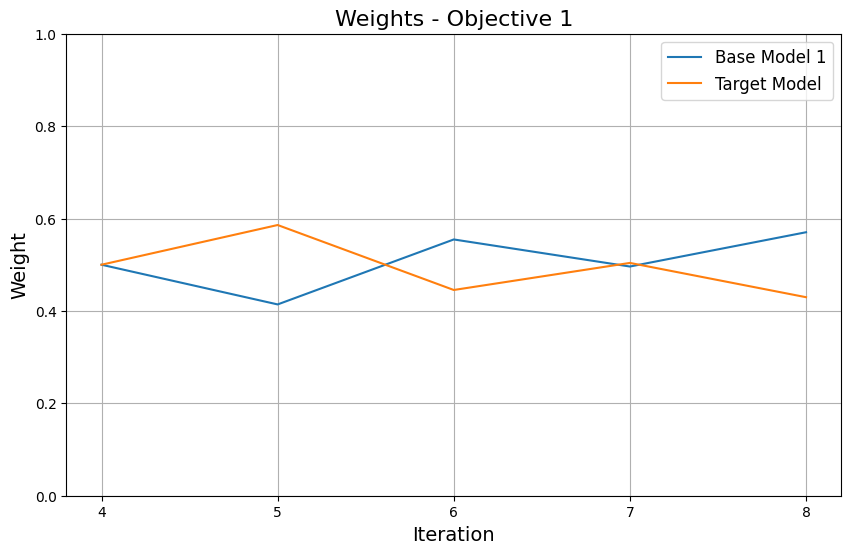

In [360]:
# Plot the weights of the models 

import matplotlib.pyplot as plt
import torch

# Convert list of tensors to a list of lists (2D array)
weight_array = torch.stack(rank_weights_1_list).numpy()

# Plot the weight of each model versus iteration
num_iterations = weight_array.shape[0]
num_models = weight_array.shape[1]

# Adjust the range of the X-axis to start at 3 (after exploration)
x_values = range(4, 4 + num_iterations)

plt.figure(figsize=(10, 6))
for model_idx in range(num_models):
    # Label first (num_models - 1) models as "Base Model {idx+1}" and the last one as "Target Model"
    if model_idx < num_models - 1:
        label = f'Base Model {model_idx + 1}'
    else:
        label = 'Target Model'
    plt.plot(x_values, weight_array[:, model_idx], label=label)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.title('Weights - Objective 1', fontsize=16)

# Adjust the X-axis ticks to have a unit interval of 1, starting from 4
plt.xticks(range(4, 4 + num_iterations, 1))

plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.ylim([0,1])
plt.show()

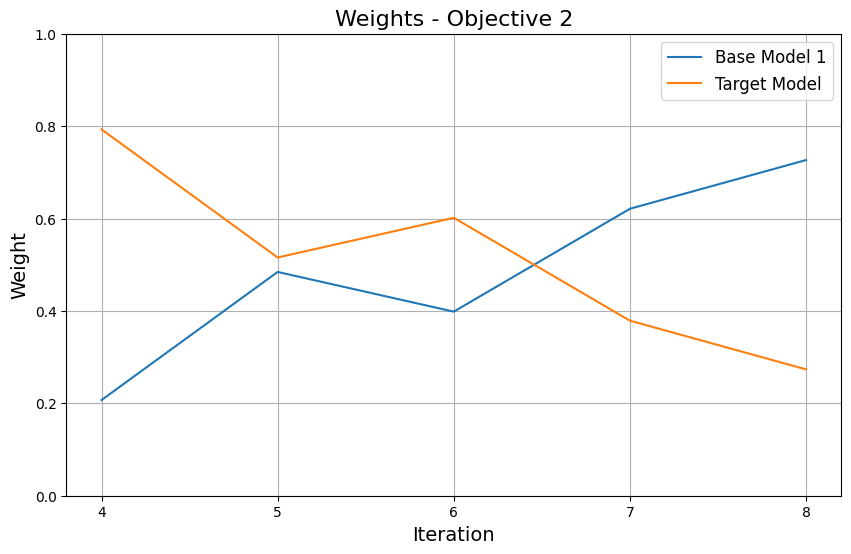

In [361]:
import matplotlib.pyplot as plt
import torch

# Convert list of tensors to a list of lists (2D array)
weight_array = torch.stack(rank_weights_2_list).numpy()

# Plot the weight of each model versus iteration
num_iterations = weight_array.shape[0]
num_models = weight_array.shape[1]

# Adjust the range of the X-axis to start at 4 (Since the first three iterations represent exploration points)
x_values = range(4, 4 + num_iterations)

plt.figure(figsize=(10, 6))
for model_idx in range(num_models):
    # Label first (num_models - 1) models as "Base Model {idx+1}" and the last one as "Target Model"
    if model_idx < num_models - 1:
        label = f'Base Model {model_idx + 1}'
    else:
        label = 'Target Model'
    plt.plot(x_values, weight_array[:, model_idx], label=label)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.title('Weights - Objective 2', fontsize=16)

# Adjust the X-axis ticks to have a unit interval of 1, starting from 3
plt.xticks(range(4, 4 + num_iterations, 1))
plt.ylim([0,1])
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

## Validation data

Percentage reduction in Metabolics (Optimal vs Unpowered): 27.40%
Percentage reduction in Metabolics (Optimal vs User Preferred): 5.16%
Percentage reduction in Symmetry Index (Optimal vs Unpowered): 23.25%
Percentage reduction in Symmetry Index (Optimal vs User Preferred): 2.82%
Percentage increase in ETC (Optimal vs Unpowered): 7.46%
Percentage increase in ETC (Optimal vs User Preferred): 5.88%


C:\Users\sruth\AppData\Local\Temp\ipykernel_23692\3403027865.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(conditions, rotation=45, ha="right")
C:\Users\sruth\AppData\Local\Temp\ipykernel_23692\3403027865.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(conditions, rotation=45, ha="right")
C:\Users\sruth\AppData\Local\Temp\ipykernel_23692\3403027865.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(conditions, rotation=45, ha="right")


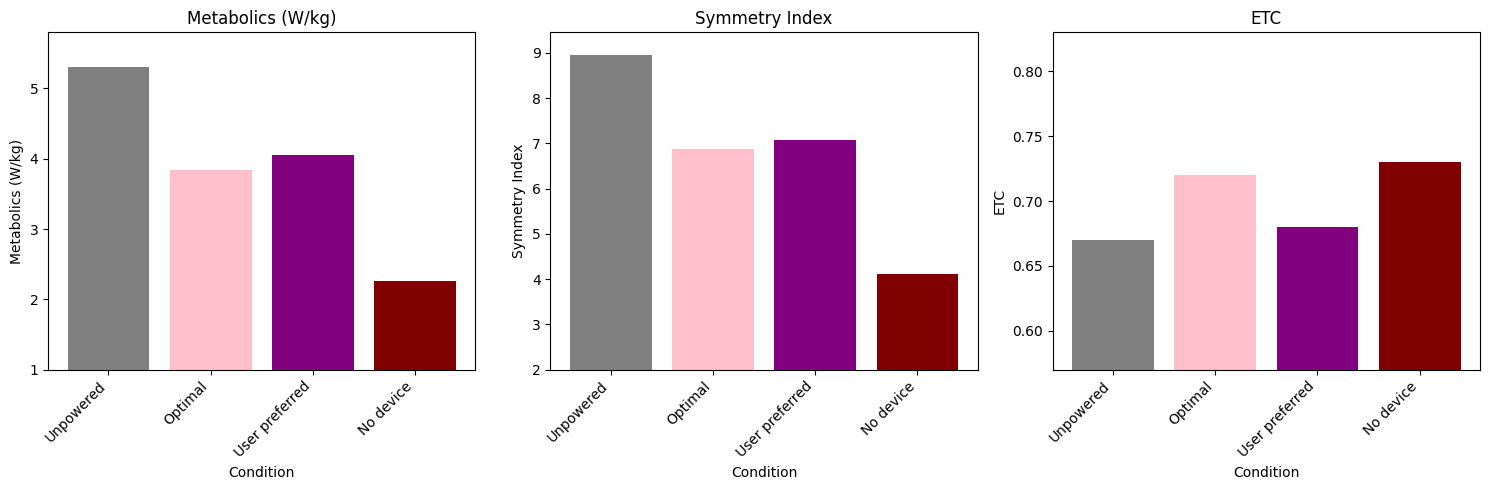

In [216]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
conditions = ['Unpowered', 'Optimal', 'User preferred', 'No device']
metabolics = [5.296712329, 3.845205479, 4.054246575, 2.264383562]
symmetry_index = [8.951563181, 6.870314358, 7.069797057, 4.110125073]
etc = [0.67, 0.72, 0.68, 0.73]

# Colors for each condition
colors = ['grey', 'pink', 'purple', 'maroon']

# Calculate percentage reductions for Metabolics (W/kg)
reduction_unpowered_metabolics = ((metabolics[0] - metabolics[1]) / metabolics[0]) * 100
reduction_user_preferred_metabolics = ((metabolics[2] - metabolics[1]) / metabolics[2]) * 100

# Calculate percentage reductions for Symmetry Index
reduction_unpowered_symmetry = ((symmetry_index[0] - symmetry_index[1]) / symmetry_index[0]) * 100
reduction_user_preferred_symmetry = ((symmetry_index[2] - symmetry_index[1]) / symmetry_index[2]) * 100

# Calculate percentage **increases** for ETC
increase_unpowered_etc = ((etc[1] - etc[0]) / etc[0]) * 100
increase_user_preferred_etc = ((etc[1] - etc[2]) / etc[2]) * 100

# Print the percentage reductions and increases
print(f"Percentage reduction in Metabolics (Optimal vs Unpowered): {reduction_unpowered_metabolics:.2f}%")
print(f"Percentage reduction in Metabolics (Optimal vs User Preferred): {reduction_user_preferred_metabolics:.2f}%")
print(f"Percentage reduction in Symmetry Index (Optimal vs Unpowered): {reduction_unpowered_symmetry:.2f}%")
print(f"Percentage reduction in Symmetry Index (Optimal vs User Preferred): {reduction_user_preferred_symmetry:.2f}%")
print(f"Percentage increase in ETC (Optimal vs Unpowered): {increase_unpowered_etc:.2f}%")
print(f"Percentage increase in ETC (Optimal vs User Preferred): {increase_user_preferred_etc:.2f}%")

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot Metabolics (W/kg)
ax1.bar(conditions, metabolics, color=colors)
ax1.set_title('Metabolics (W/kg)')
ax1.set_xlabel('Condition')
ax1.set_ylabel('Metabolics (W/kg)')
ax1.set_xticklabels(conditions, rotation=45, ha="right")
ax1.set_ylim(1, max(metabolics) + 0.5)

# Plot Symmetry Index
ax2.bar(conditions, symmetry_index, color=colors)
ax2.set_title('Symmetry Index')
ax2.set_xlabel('Condition')
ax2.set_ylabel('Symmetry Index')
ax2.set_xticklabels(conditions, rotation=45, ha="right")
ax2.set_ylim(2, max(symmetry_index) + 0.5)

# Plot ETC
ax3.bar(conditions, etc, color=colors)
ax3.set_title('ETC')
ax3.set_xlabel('Condition')
ax3.set_ylabel('ETC')
ax3.set_xticklabels(conditions, rotation=45, ha="right")
ax3.set_ylim(min(etc) - 0.1, max(etc) + 0.1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()